In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
print('modules imported')

modules imported


In [2]:
# Read data
transactions = pd.read_csv("/home/sang/UVM/database/HnM/transactions_train.csv")
articles = pd.read_csv("/home/sang/UVM/database/HnM/articles.csv")
customers = pd.read_csv("/home/sang/UVM/database/HnM/customers.csv")

In [3]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [4]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [6]:
# Sort data by 'product type name'
prod_type = articles["product_type_name"].value_counts().reset_index().head(15)
total_prod_types = articles["product_type_name"].nunique()

In [7]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

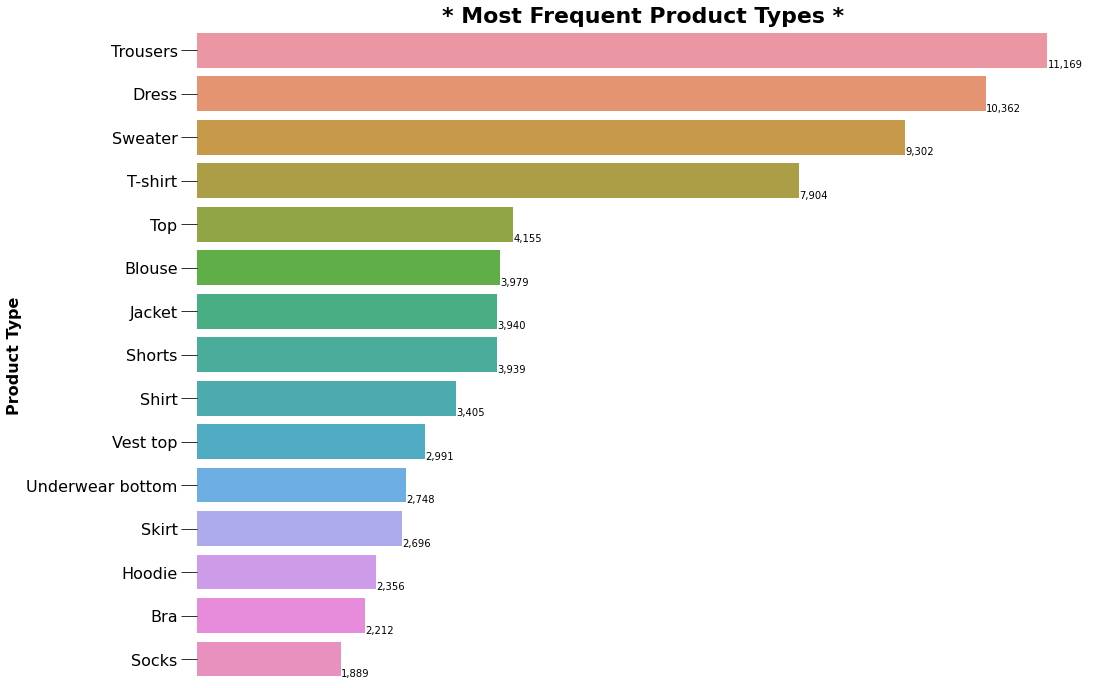

In [8]:
# Plot
fig, ax = plt.subplots(figsize=(16, 12))
plt.title('* Most Frequent Product Types *', size=22, weight="bold")

sns.barplot(data=prod_type, x="product_type_name", y="index", ax=ax,)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Type", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

sns.despine(left=True, bottom=True)
plt.show();

# Top 4 product types are 'Trousers', 'Dress', 'Sweater', 'T-shirt'

In [45]:
def str_check(lst):
    return all([isinstance(l, str) for l in lst])
def elem_check(lst, lst2):
    return all([l in lst2 for l in lst])

def dtype_checker(lst, ref):
    try:
        assert len(lst) > 0, "empty product type list"
        assert str_check(lst) == True, "elements of product type list should be string"
        assert elem_check(lst, ref) == True, "At least one element is not in the reference list"
        print("list format checked")
    except AssertionError as msg:
        print(msg)

In [47]:
prod_type_lst = ['Trousers', 'Dress', 'Sweater', 'T-shirt']
lst_checker(prod_type_lst)

list format checked


In [54]:
class Prod_analysis:
    def __init__(self, articles, transactions, prod_type_lst):
        self.str = "prod_type_lst: list of product type \n"\
        "m_articles: master dataframe of articles \n"\
        "m_article_set: unique set of articles in m_articles \n"\
        "m_transactions: master transaction dataframe containing m_article_set"
        
        dtype_checker(prod_type_lst, articles["product_type_name"].unique())
        
        self.prod_type_lst = prod_type_lst
        self.m_articles = articles.loc[articles["product_type_name"].isin(prod_type_lst)].reset_index()
        self.m_article_set = self.m_articles['article_id'].unique()
        self.m_transactions = transactions.loc[transactions['article_id'].isin(self.m_article_set)]
        
        print("master dataframe generated")
    
    def __str__(self):
        intro = "This is class instance containing"\
        "datafrom of articles and transactions with product types in the product type list"
        return intro+"\n"+self.str[1:-1]
    
    def make_t_daily_dict(self, type_lst = None):
        if isinstance(type_lst, list):
            lst_checker(type_lst, self.prod_type_lst)
        elif type_lst == None:
            type_lst = self.prod_type_lst
        else:
            print("type list should be a list containing product types")
            return None
        
        self.output_dict = {}
        for tp in type_lst:
            _tp_set = self.m_articles.loc[self.m_articles["product_type_name"] == tp]['article_id'].unique()
            _tp_trans = self.m_transactions.loc[self.m_transactions['article_id'].isin(_tp_set)]
            self.output_dict[tp] = (_tp_trans[['t_dat','article_id','price']].groupby('t_dat')
                    .agg({'article_id':'count', 'price': 'sum'})
                    .reset_index()
                    .rename(columns={'article_id':'n_sold', 'price': 'sales'})
                   )
            self.output_dict[tp].set_index('t_dat', inplace=True)
            self.output_dict[tp].index = pd.to_datetime(trousers_t_daily.index)
        print("Output is a dictionary w/ key=product type, val=daily dataframe")
        return self.output_dict

In [80]:
def t_monthly_from_t_daily(t_daily_dict, ptype):
    return t_daily_dict[ptype].resample('M').mean()
    
def simple_sales(t_monthly):
    plt.figure(figsize=(24, 1.5))
    ax = sns.barplot(x=t_monthly.index.strftime("%Y/%m"), 
                y=t_monthly['sales'], 
                )
    if len(t_monthly.index) > 1000:
        ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.tick_params(bottom=False)

In [55]:
prod_type_lst = ['Trousers', 'Dress', 'Sweater', 'T-shirt']
m_df = Prod_analysis(articles, transactions, prod_type_lst)

list format checked
master dataframe generated


In [56]:
t_daily_dict = m_df.make_t_daily_dict()

Output is a dictionary w/ key=product type, val=daily dataframe


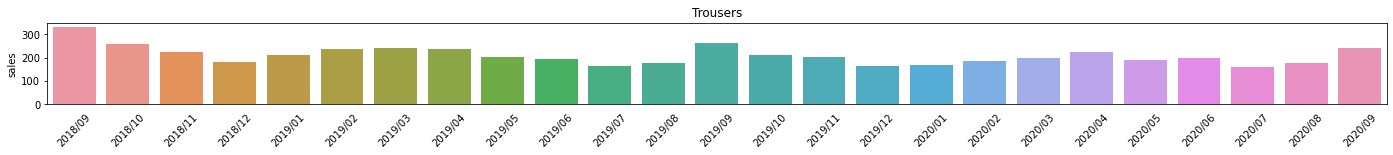

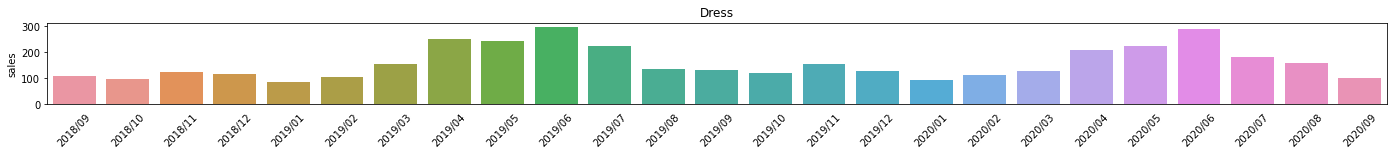

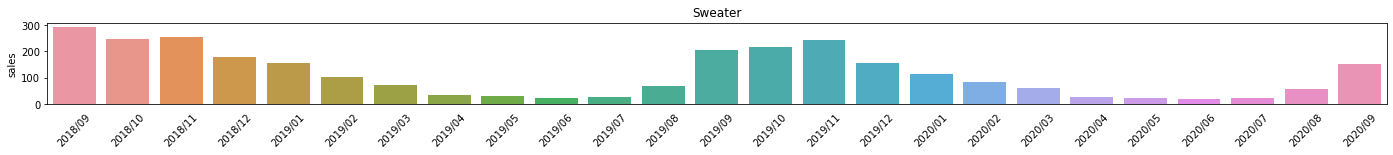

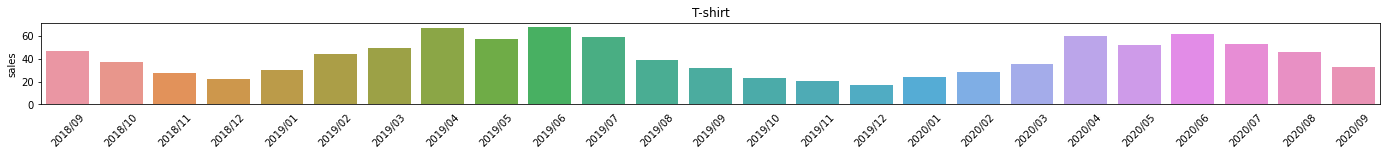

In [81]:
t_monthly_dict = {}
for tp in prod_type_lst:
    t_monthly_dict[tp] = t_monthly_from_t_daily(t_daily_dict, tp)
    simple_sales(t_monthly_dict[tp])
    plt.title(tp)
    plt.show()

# Strategy 1:
## input is time series of T-shirt

In [95]:
target = "T-shirt"
print("starting date:", t_daily_dict[target].index[0].strftime("%Y-%m-%d"))
print("ending date:", t_daily_dict[target].index[-1].strftime("%Y-%m-%d"))
split_date = datetime.strptime('2020-09-01', "%Y-%m-%d")
val_date = datetime.strptime('2020-08-01', "%Y-%m-%d")
print("split date:", split_date.strftime("%Y-%m-%d"))

starting date: 2018-09-20
ending date: 2020-09-22
split date: 2020-09-01


In [98]:
# split data
df = t_daily_dict[target]
s1_train = df.loc[df.index <= val_date].copy()
s1_val = df.loc[(df.index > val_date)&(df.index < split_date)].copy()
s1_test = df.loc[df.index > split_date].copy()
print("length of train set:",len(s1_train))
print("length of val set:",len(s1_val))
print("length of test set:",len(s1_test))

length of train set: 682
length of val set: 30
length of test set: 21


In [113]:
def feature_generator(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int')
    
    x = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return x, y
    return x

In [114]:
x_train, y_train = feature_generator(s1_train, 'sales')
x_val, y_val = feature_generator(s1_val, 'sales')
x_test, y_test = feature_generator(s1_test, 'sales')

In [119]:
reg = xgb.XGBRegressor(n_estimators=1000, seed = 45,
                      alpha = 0.1,eta = 0.1,)

reg.fit(x_train, y_train,
        eval_metric="rmse",
        eval_set=[(x_train, y_train), (x_val, y_val)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:41.46135	validation_1-rmse:43.05978
[1]	validation_0-rmse:37.75675	validation_1-rmse:39.88323
[2]	validation_0-rmse:34.40909	validation_1-rmse:36.98707
[3]	validation_0-rmse:31.41993	validation_1-rmse:34.34555
[4]	validation_0-rmse:28.72720	validation_1-rmse:31.97581
[5]	validation_0-rmse:26.33041	validation_1-rmse:29.85151
[6]	validation_0-rmse:24.15066	validation_1-rmse:27.80983
[7]	validation_0-rmse:22.20557	validation_1-rmse:25.98369
[8]	validation_0-rmse:20.48544	validation_1-rmse:24.48267
[9]	validation_0-rmse:18.92613	validation_1-rmse:23.15855
[10]	validation_0-rmse:17.54120	validation_1-rmse:21.98924
[11]	validation_0-rmse:16.28149	validation_1-rmse:20.92982
[12]	validation_0-rmse:15.18433	validation_1-rmse:19.98166
[13]	validation_0-rmse:14.13236	validation_1-rmse:18.94401
[14]	validation_0-rmse:13.16783	validation_1-rmse:18.22619
[15]	validation_0-rmse:12.30617	validation_1-rmse:17.58324
[16]	validation_0-rmse:11.49817	validation_1-rmse:16.92791
[17]	va

[141]	validation_0-rmse:1.74181	validation_1-rmse:11.07231
[142]	validation_0-rmse:1.73533	validation_1-rmse:11.06342
[143]	validation_0-rmse:1.71504	validation_1-rmse:11.05892
[144]	validation_0-rmse:1.70107	validation_1-rmse:11.05917
[145]	validation_0-rmse:1.67133	validation_1-rmse:11.05921
[146]	validation_0-rmse:1.64499	validation_1-rmse:11.05925
[147]	validation_0-rmse:1.62931	validation_1-rmse:11.05902
[148]	validation_0-rmse:1.61329	validation_1-rmse:11.05621
[149]	validation_0-rmse:1.58960	validation_1-rmse:11.05617
[150]	validation_0-rmse:1.58432	validation_1-rmse:11.05635
[151]	validation_0-rmse:1.56291	validation_1-rmse:11.05629
[152]	validation_0-rmse:1.54941	validation_1-rmse:11.03790
[153]	validation_0-rmse:1.54313	validation_1-rmse:11.03684
[154]	validation_0-rmse:1.52800	validation_1-rmse:11.03435
[155]	validation_0-rmse:1.51908	validation_1-rmse:11.03242
[156]	validation_0-rmse:1.51822	validation_1-rmse:11.03220
[157]	validation_0-rmse:1.51265	validation_1-rmse:11.032

[279]	validation_0-rmse:0.83497	validation_1-rmse:10.91176
[280]	validation_0-rmse:0.82869	validation_1-rmse:10.91634
[281]	validation_0-rmse:0.82749	validation_1-rmse:10.91125
[282]	validation_0-rmse:0.82481	validation_1-rmse:10.91112
[283]	validation_0-rmse:0.81663	validation_1-rmse:10.91103
[284]	validation_0-rmse:0.81438	validation_1-rmse:10.91095
[285]	validation_0-rmse:0.81121	validation_1-rmse:10.91193
[286]	validation_0-rmse:0.80889	validation_1-rmse:10.91181
[287]	validation_0-rmse:0.80280	validation_1-rmse:10.91600
[288]	validation_0-rmse:0.79987	validation_1-rmse:10.90801
[289]	validation_0-rmse:0.79748	validation_1-rmse:10.91442
[290]	validation_0-rmse:0.79168	validation_1-rmse:10.91898
[291]	validation_0-rmse:0.79080	validation_1-rmse:10.92154
[292]	validation_0-rmse:0.78580	validation_1-rmse:10.92556
[293]	validation_0-rmse:0.78563	validation_1-rmse:10.92548
[294]	validation_0-rmse:0.78363	validation_1-rmse:10.92620
[295]	validation_0-rmse:0.78221	validation_1-rmse:10.925

XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=45,
             reg_alpha=0.100000001, reg_lambda=1, scale_pos_weight=1, seed=45,
             subsample=1, tree_method='exact', validate_parameters=1, ...)

In [120]:

Y_pred = reg.predict(x_val)
Y_test = reg.predict(x_test)

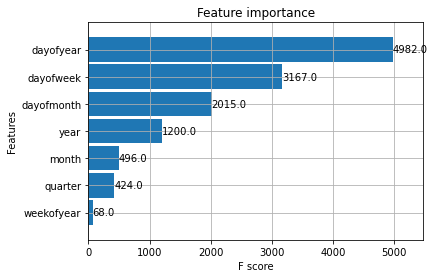

In [121]:
_ = plot_importance(reg, height=0.9)

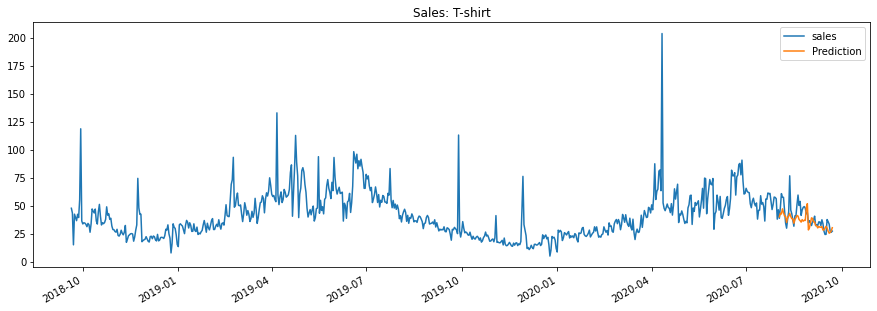

In [127]:
s1_val['Prediction'] = Y_pred
s1_test['Prediction'] = Y_test
df_all = pd.concat([s1_train, s1_val, s1_test], sort=False)

f1 = df_all[['sales','Prediction']].plot(title = "Sales: T-shirt", figsize=(15, 5), xlabel = "")\
    .get_figure().savefig('Tshirt.png')


# Strategy 2:
## input is time series of vector with four products